# Imports

In [1]:
!pwd
import os
import shutil
import matplotlib.pyplot as plt
import numpy
import pandas

from molgroups.support import molstat
from molgroups.ml import playground

# always use the same testdata
shutil.copyfile('./bu/sim.dat', os.getcwd()+'/sim.dat')

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/ml/EllipsoidProtein_SingleDataset


/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/ml/EllipsoidProtein_SingleDataset/sim.dat'

# Variables for example fit and optimization

In [2]:
# Run Optimization or only example fit and data simulation
RunFit=False
RunOptimization=False

# Folders and fit application
store = "T"
setupdir = os.getcwd()
runfile = "run"
fitsource = "SASView"

# MCMC fit iterations in example fit and optimization
burn=100
steps=100

# enforced qmin and qmax, even if detector would cover larger q-range
# alternatively: take enforced q-range from first provided data file (index 0)
# set total counting time for the entire experiment (in s), or None
# number of gpcam iterations, if gpcam is used
qmin = 0.001
qmax = 0.8
qrangefromfile = False
t_total = None
optimizer = 'grid'  # optimizer can be 'grid' or gpcam
fitter = 'MCMC'  # fit driver for optimization either 'MCMC' or 'LM'
remove_fit_dir = False # Keep fit directories for inspection of individual simulated fits

# only used for gpcam optimizer
gpcam_iterations = 1200
gpcam_init_dataset_size = 200  # usually 20
gpcam_step = 10                # at least 2 to make use of local and global optimization
# Acquisition Functions. Use "variance" for pure exploration, 'maximum' to zero in on an already identified information gain maximum, 'ucb' for an exploration-exploitation balance, and 'shannon_ig_vec' for a maximization in information gain.
acq_func='ucb'

# only used for grid optimizer
convergence = 2.0           # convergence criteria for internal robustness check
miniter = 1                # minimum number of samples per grid point, chose at least 2 for error bars
bcalcsymmetric = True       # if problem is symmetric in variable parameters, should symmetric solutions be calculated twice?

# isotropic scattering background
# user-defined linear relationship between a SLD of the bulk solvent and the differential macroscopic scattering crosssection of the buffer
#cross_section_background = {'slope':-0.1626, 'y_intercept': 0.7980}  # acetonitrile
#mode = 'SANS_linear'
# presets for water
mode = 'water'
cross_section_background = None

# Prepare gpcam to keep plots for individual iterations and make fine enough steps between record keeping. Useful for constructing a movie.
# If not needed, set keep_plots to False, init dataset size to 20, do not show support points, and set gpcam steps to None
keep_plots = False
show_support_points = False

## misc entropy setup
bClusterMode = False
bFetchMode = False
time = 2
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = ['#!/bin/bash\n',
          '#SBATCH --job-name=entro {mcmc_iteration}\n',
          '#SBATCH -A mc4s9np\n', '#SBATCH -p RM\n',
          '#SBATCH -t 0' + str(time) + ':00:00\n',
          '#SBATCH -N 4\n', '#SBATCH --ntasks-per-node 28\n',
          '\n',
          'set +x\n',
          'cd $SLURM_SUBMIT_DIR\n',
          '\n',
          'module load python/2.7.11_gcc\n',
          'export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n',
          '\n',
          'mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time='
          + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn)
          + ' --steps=' + str(steps) + '\n'
          ]
# script.append('cd '+dirname+'\n')

# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%writefile run.py
from bumps.names import *
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data

# IMPORT THE DATA USED
data = load_data('sim.dat')

#setattr(data, 'qmin', 0.01)
#setattr(data, 'qmax', 10.0)

# DEFINE THE MODEL
kernel = load_model('ellipsoid@hayter_msa')

pars = dict(scale=1.0, background=0.0005, sld=3.4, sld_solvent=6.4, radius_polar=14.0,
            radius_equatorial=12.0, volfraction=0.075, charge=5, temperature=298.0,
            concentration_salt=0.150, dielectconst=71.08)

model = Model(kernel, **pars)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
# model.scale.range(0.1, 7.)
# model.background.range(0, 1)
# model.sld.range(-2, 10)
# model.sld_solvent.range(0, 5)
model.radius_polar.range(17, 35)
model.radius_equatorial.range(5, 17)
model.volfraction.range(0.0001,0.02)
# model.charge.range(0, 20)
# model.temperature.range(0, 1000)
# model.concentration_salt.range(0, 1)
# model.dielectconst.range(0,100)

M = Experiment(data=data, model=model)
problem = FitProblem(M)

Overwriting run.py


# Run Example Fit

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    # remove store directory if it already exists, since we do not want to reload here
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

fitobj.fnRestoreFit()

## Test Data Simulation
### 1. Show Best-fit parameters from above fit

In [5]:
fitobj.fnLoadParameters()
pf = pandas.DataFrame(fitobj.diParameters)
pf

,radius_equatorial,radius_polar,volfraction
number,0,1,2
lowerlimit,5.0,17.0,0.0001
upperlimit,17.0,35.0,0.02
value,13.141075,25.342221,0.002125
relval,0.678423,0.463457,0.101745
variable,radius_equatorial,radius_polar,volfraction
error,0.01,0.01,0.01


2. Define simulation model parameters. They are written out to simpar.dat. Please change to desired values or copy from dataframe above.

In [6]:
simpar = pandas.DataFrame(pf.loc['value'])
simpar.reset_index(inplace=True)
simpar.columns = ['par', 'value']
simpar

,par,value
0,radius_equatorial,13.141075
1,radius_polar,25.342221
2,volfraction,0.002125


3. Define Instrument configurations. Each dataset can have its own instrument configuration. In the example below, a single configuration is assigned to all datasets. The configuration is made of three settings with different sample-detector distances.

In [7]:
sb = 0.059
configuration_dataset1 = [{'lambda': 6.21,
                            "sample_detector_distance": 100,
                            'source_sample_distance': 387.6,
                            'source_aperture_radius':5.08*0.5,
                            'sample_aperture_radius':1.27*0.5,
                            "beamstop_diameter": 10.16,
                            "neutron_flux": 5e4,
                            'time': 1600,
                            'beam_center_x': 25,
                            "dlambda_lambda":0.136,
                            "differential_cross_section_buffer": sb},
                          {'lambda': 6.21,
                           "sample_detector_distance": 400,
                           'source_sample_distance': 850.05,
                           'source_aperture_radius':5.08*0.5,
                           'sample_aperture_radius':1.27*0.5,
                           "beamstop_diameter": 10.16,
                           "neutron_flux": 4e4,
                           'time': 3600,
                           "dlambda_lambda":0.136,
                           "differential_cross_section_buffer": sb},
                         {'lambda': 6.21,
                          "sample_detector_distance": 1300,
                          'source_sample_distance': 1467,
                          'source_aperture_radius':5.08*0.5,
                          'sample_aperture_radius':1.27*0.5,
                          "dlambda_lambda":0.136,
                          "beamstop_diameter": 10.16,
                          "neutron_flux": 4e4,
                          'time': 4400,
                          "differential_cross_section_buffer": sb}]

configuration = [configuration_dataset1]

4. Visually check configuration.

In [8]:
df = pandas.DataFrame.from_dict(configuration_dataset1)
df

,lambda,sample_detector_distance,source_sample_distance,source_aperture_radius,sample_aperture_radius,beamstop_diameter,neutron_flux,time,beam_center_x,dlambda_lambda,differential_cross_section_buffer
0,6.21,100,387.60,2.54,0.635,10.16,50000.0,1600,25.0,0.136,0.059
1,6.21,400,850.05,2.54,0.635,10.16,40000.0,3600,NaN,0.136,0.059
2,6.21,1300,1467.00,2.54,0.635,10.16,40000.0,4400,NaN,0.136,0.059


5. Simulate data.

In [9]:
fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=qmin, qmax=qmax, t_total=None, simpar=simpar)

                 par      value
0  radius_equatorial  13.141075
1       radius_polar  25.342221
2        volfraction   0.002125
[[{'lambda': 6.21, 'sample_detector_distance': 100, 'source_sample_distance': 387.6, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 50000.0, 'time': 1600, 'beam_center_x': 25, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.059}, {'lambda': 6.21, 'sample_detector_distance': 400, 'source_sample_distance': 850.05, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 40000.0, 'time': 3600, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.059}, {'lambda': 6.21, 'sample_detector_distance': 1300, 'source_sample_distance': 1467, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'dlambda_lambda': 0.136, 'beamstop_diameter': 10.16, 'neutron_flux': 40000.0, 'time': 4400, 'differential_cross_section_buffer': 0

/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


### Compare original and simulated data.
1. Compare Data

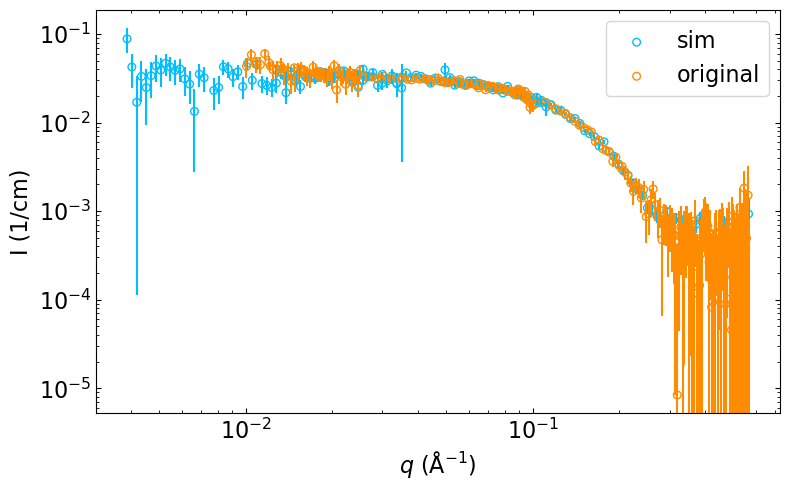

In [10]:
import pandas

fig, ax = plt.subplots()

original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.errorbar(simdata['Q'], simdata['I'], simdata['dI'], ls='none', color='deepskyblue')
ax.scatter(simdata['Q'], simdata['I'], s=30, marker='o', facecolors='none', edgecolors='deepskyblue', label='sim')
ax.errorbar(original['Q'], original['I'], original['dI'], ls='none', color='darkorange')
ax.scatter(original['Q'], original['I'], s=30, marker='o', facecolors='none', edgecolors='darkorange', label='original')

ax.legend(fontsize=16)
ax.set_ylabel("I (1/cm)", fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8, 5)
#ax.set_ylim(1e-2, .1)
plt.tight_layout()
plt.savefig(store + "/intensity_comparison.png", facecolor="white")
plt.show()


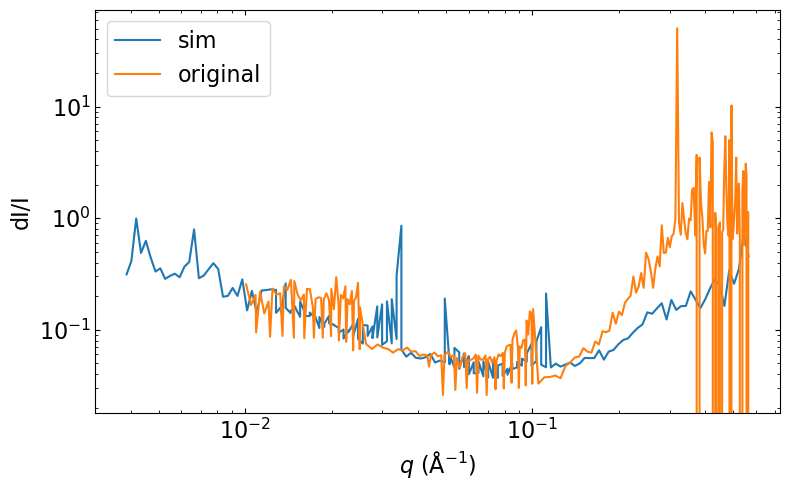

In [11]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.plot(simdata['Q'], (simdata['dI']/simdata['I']), label="sim")
ax.plot(original['Q'], (original['dI']/original['I']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("dI/I", fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8, 5)
#ax.set_ylim(0, 0.25)
plt.tight_layout()
plt.savefig(store + "/uncertainty_comparison.png", facecolor="white")
plt.show()


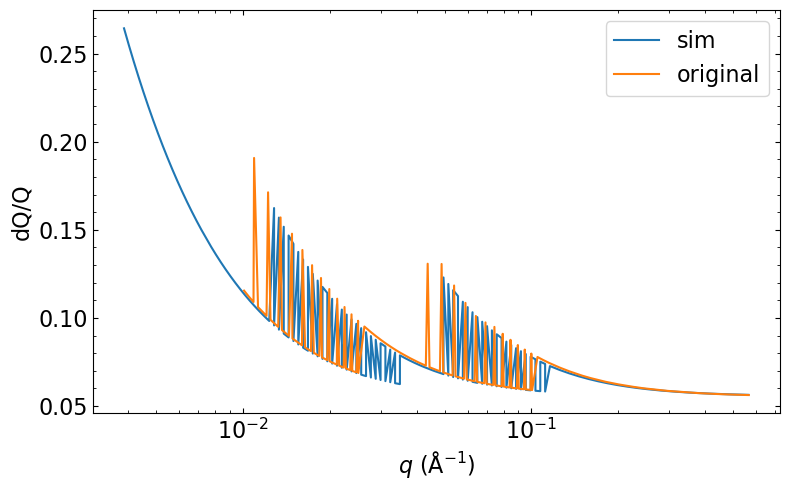

In [12]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim.dat', sep=' ', skip_blank_lines=True,comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=16)
ax.set_ylabel("dQ/Q", fontsize=16)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
ax.figure.set_size_inches(8., 5)
#ax.set_ylim(0, 0.01)
plt.tight_layout()
plt.savefig(store + "/resolution_comparison.png", facecolor="white")
plt.show()


In [13]:
simdata = fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=qmin, qmax=qmax, t_total=None, simpar=simpar, save_file=False, verbose=False)[0][1]
simdata

/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq


,Q,I,dI,dQ
517,0.004019,0.022323,0.017493,0.001024
518,0.004177,0.056853,0.016831,0.001026
519,0.004342,0.059896,0.016194,0.001028
521,0.004691,0.031122,0.014992,0.001032
522,0.004875,0.031251,0.014425,0.001035
...,...,...,...,...
169,0.484104,0.000795,0.000121,0.027422
170,0.503176,0.000614,0.000119,0.028461
171,0.522999,0.000587,0.000148,0.029542
172,0.543602,0.000351,0.000207,0.030667


# Machine Learning

In [14]:
fitobj.fnRestoreFit()

In [15]:
import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)


train_x = []
train_y = []
for i in range(10000):
    parlimits = []
    for par in pf:
        pf[par]['value'] = numpy.random.random() * (pf[par]['upperlimit'] - pf[par]['lowerlimit']) + pf[par]['lowerlimit']
    simpar = pandas.DataFrame(pf.loc['value'])
    simpar.reset_index(inplace=True)
    simpar.columns = ['par', 'value']
    simdata = fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=qmin, qmax=qmax, t_total=None, simpar=simpar, save_file=False, verbose=False)[0][1]

    train_x.append(simdata)
    train_y.append(simpar)

fnSaveObject(train_x, "train_x.dat")
fnSaveObject(train_y, "train_y.dat")


/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python39/lib/python3.9/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank